# Pizzeria DiMari

### Background 

Giuseppe DiMari is a renowned business man from little Italy, Manhattan. He has a few restaurants, mainly pizzerias, in that neighbourhood and he is thinking on expanding his operation into other neighbourhoods in other towns in America although he does not discard further growth in NY. Giuseppe has some friends in Chicago, Miami and Toronto. Thus he would like to select which neighbourhoods are the most similar to Little Italy based on the competition and nearby venues so that he can create a business in there. He is not just interested in one only neighbourhood, he wants a group of neighbourhoods he can chose from. If there are also neighbourhoods in NY that are similar to Little Italy, he would like to know those as well. Also, he is not particularly afraid of the competition, if anything, he prefers a neighborhood with competition since he know that this will help his Pizzeria to stay at its best. After all, it will be his inexperienced brother, Julio DiMari, who will be managing the restaurant. And he needs some healthy competition to become a successful business man.



### Objective
Identify which neighbourhoods are the most similar to Little Italy(NY) in Miami, Chicago, Toronto and the broader neighbourhoods from NY. From these, identify which ones have enough competition.

### Methodology
1. We will obtain all the Neighbourhoods from Toronto, Miami, Chicago and NY. Neighbourhood data will be downloaded from Wikipedia or use existing data from other course modules. This data will be cleansed to ensure that these hoods are indeed in these cities. Based on my experience, Geolocator can give wrong locations if the address isn't sufficiently clear.

2. We will obtain all the venues per neighbourhood from  Foursquare. We will characterise each neighbourhood using the most common types of venue. This will be done by using the one hot encoding.

3. We will classify the neighbourhoods into clusters based on the types of common venues using K-mean clusters. Number of clusters will also be optimised so that there  are no more than 25 similar neighbourhoods in that group. The list of neighoorhoods has to be sufficiently small for Giuseppe,

4. The cluster that contains Little Italy, NY, will be the target subgroup of neighbourhoods.

5. After clustering, we will find those neighborhoods that do have a pizzeria or an italian restaurant in the top 3 common venues.


In [119]:
# Import Toronto data
from __future__ import division, unicode_literals 
import pandas as pd
import numpy as np

import requests #to read HTML pages

! pip install BeautifulSoup4 

from bs4 import BeautifulSoup

#url of wikipedia
website_url = requests.get('http://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

#read the right table
soup = BeautifulSoup(website_url,'lxml')
wikitable=soup.find('table',{'class':'wikitable sortable'})

#get the table column atributes
header=[th.text.rstrip() for th in wikitable.find_all('th')]

#get the data from the table
torontorawdata=[td.text.rstrip() for td in wikitable.find_all('td')]

#transform the data into lists
PostalCode=[]
Borough=[]
Neighbourhood=[]

lengthoftorontorawdata=len(torontorawdata)

i=0
while i < lengthoftorontorawdata:
    PostalCode.append(torontorawdata[i])
    Borough.append(torontorawdata[i+1])
    Neighbourhood.append(torontorawdata[i+2])
    i=i+3

#build matrix with lists
rawdata=np.array([PostalCode,Borough,Neighbourhood])
rawdata=rawdata.transpose()


#build a df were we will store all the list data
torontodata=pd.DataFrame(rawdata, columns=[header[0],header[1],header[2]])

#remove all the cases in which there is no Borough assigned
NoBoroughIndex=torontodata[torontodata['Borough']=='Not assigned'].index
torontodata.drop(NoBoroughIndex , inplace=True)

#for all those cases in which the Neighbourhood is 'Not assigned' we will copy the name of the Borough
NoNeighbourIndex=torontodata[torontodata['Neighbourhood']=='Not assigned'].index

lengthofnoneighbour=len(NoNeighbourIndex)

i=0
while i < lengthofnoneighbour:
    torontodata.at[NoNeighbourIndex[i],'Neighbourhood']=torontodata.at[NoNeighbourIndex[i],'Borough']
    i=i+1
   

# by postcode

cleantorontodata=torontodata.groupby(['Postal Code','Borough'])['Neighbourhood'].apply(','.join).reset_index()

Obtained this table from wikipedia

In [120]:
cleantorontodata

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."


In [121]:
#read the coordinates data from the CSV


!wget -q -O 'Geospatial_data.csv' http://cocl.us/Geospatial_data

coordinates = pd.read_csv('Geospatial_data.csv')


In [122]:
#create two lists that we will add to the dataframe of toronto
Latitude=[]
Longitude=[]

#sort the CSV file by Postal Code
coordinatesorted=coordinates.sort_values(by="Postal Code")
Latitude=coordinatesorted['Latitude']
Longitude=coordinatesorted['Longitude']

#sort the Torontodata by postal code
cleantorontodatasorted=cleantorontodata.sort_values(by="Postal Code")

#add the columns latitude and longitude to the cleantorontodatasorted dataframe
cleantorontodatasorted['Latitude']=Latitude
cleantorontodatasorted['Longitude']=Longitude


Transformed dataframe, it has Postal Code, Borough, Neighbourhood, Latitude and Longitude

In [123]:
cleantorontodatasorted

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437


In [124]:
#load all the libraries

import json # library to handle JSON files

! pip install geopy

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
! pip install folium

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [125]:
address = 'Toronto, CA'

geolocator = Nominatim(user_agent="To_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [126]:
# we will focus only on the boroughs from toronto
toronto_data = cleantorontodatasorted[cleantorontodatasorted['Borough'].str.contains('Toronto')].reset_index(drop=True)


In [127]:
#Note that the dataframe of Toronto also includes Postal Code. We will remove the postal code and we will join these two dataframes into one
toronto_data=toronto_data.drop(columns="Postal Code")

In [128]:
# note also that in the toronto Dataframe the column is listed as "Neighbourhood" whereas in the NY one is listed as "Neighborhood"
toronto_data=toronto_data.rename(columns={"Neighbourhood": "Neighborhood"})

#also, for simiplicity, we will add a column at the end of dataframe to know which is the neighborhood from. For toronto we will add TO

city=[]
for cells in toronto_data["Borough"]:
    city.append('TO')
    
toronto_data["City"]=city

In [130]:
#now lets plot all the hoods from toronto to confirm we are content with it
hoods = folium.map.FeatureGroup()
address="Toronto, CA"
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in zip(toronto_data.Latitude, toronto_data.Longitude):
    hoods.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
toronto_map.add_child(hoods)

In [ ]:
#confirmed that all the hoods are within Toronto

Now we will do the same for New York hoods (we will look at all of them, not just manhatan)

In [131]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    
neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

#Then let's loop through the data and fill the dataframe one row at a time.
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
#also, for simiplicity, we will add a column at the end of dataframe to know which is the neighborhood from. For toronto we will add TO

city=[]
for cells in neighborhoods["Borough"]:
    city.append('NY')
    
neighborhoods["City"]=city

neighborhoods.head()

Data downloaded!


,Borough,Neighborhood,Latitude,Longitude,City
0,Bronx,Wakefield,40.894705,-73.847201,NY
1,Bronx,Co-op City,40.874294,-73.829939,NY
2,Bronx,Eastchester,40.887556,-73.827806,NY
3,Bronx,Fieldston,40.895437,-73.905643,NY
4,Bronx,Riverdale,40.890834,-73.912585,NY


In [132]:
#lets print all the hoods from NY city
hoods = folium.map.FeatureGroup()
address="New York City, NY"
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
NY_map = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, in zip(neighborhoods.Latitude, neighborhoods.Longitude):
    hoods.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
NY_map.add_child(hoods)

In [ ]:
#looks like all the neighbhourhoods are only in NY which is good

In [ ]:
#Now we need to get the hoods of Chicago. Interestingly Chicago isnt divided into "Borouhgs" like toronto. It is divided into Community areas. We will be downloading the data exactly as we did for Toronto and we wil rename the column "community areas" to "Boroughs". 

In [133]:
#url of wikipedia
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Chicago').text

#read the right table
soup = BeautifulSoup(website_url,'lxml')
wikitable=soup.find('table',{'class':'wikitable sortable'})

#get the table column atributes
header=[th.text.rstrip() for th in wikitable.find_all('th')]

#get the data from the table
chicagorawdata=[td.text.rstrip() for td in wikitable.find_all('td')]

#transform the data into lists
Neighborhood=[]
CommunityArea=[]
lengthofchicagorawdata=len(chicagorawdata)

i=0
while i < lengthofchicagorawdata:
    Neighborhood.append(chicagorawdata[i])
    CommunityArea.append(chicagorawdata[i+1])
    i=i+2

#build matrix with lists
rawdata=np.array([CommunityArea,Neighborhood])
rawdata=rawdata.transpose()


#build a df were we will store all the list data
chicagodata=pd.DataFrame(rawdata, columns=[header[1],header[0]])

chicagodata

# by community area

cleanchicagodata=chicagodata.groupby(['Community area'])['Neighborhood'].apply(','.join).reset_index()

#now lets change the columns header from "community area" to "borough"

cleanchicagodata=cleanchicagodata.rename(columns={"Community area": "Borough"})

cleanchicagodata

,Borough,Neighborhood
0,Albany Park,"Albany Park,Mayfair,North Mayfair,Ravenswood M..."
1,Archer Heights,Archer Heights
2,Armour Square,"Armour Square,Chinatown,Wentworth Gardens"
3,Ashburn,"Ashburn,Ashburn Estates,Beverly View,Crestline..."
4,Auburn Gresham,"Auburn Gresham,Gresham"
...,...,...
77,West Pullman,West Pullman
78,West Ridge,"Nortown,Peterson Park,Rosehill,West Ridge,West..."
79,West Town,"East Village,Noble Square,Pulaski Park,River W..."
80,"West Town, Logan Square",Polish Downtown


In [ ]:
#Now we will add the latide and longitude for each borough

In [134]:
# geopy was installed before already

address = 'Albany Park, CH'

geolocator = Nominatim(user_agent="To_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

#create two lists
LATITUDE=[]
LONGITUDE=[]

address

# there are 82 borouhs in Chicago 
i=0
while i < 82 :
    address = "%s, %s" % (cleanchicagodata.iloc[i][0], "CH")
    location = geolocator.geocode(address)
    if location is None:
        latitude = "Error"
        longitude = "Error"
    else :
        latitude= location.latitude
        longitude = location.longitude
    LATITUDE.append(latitude)
    LONGITUDE.append (longitude)
    i=1+i
        
cleanchicagodata["Latitude"]=LATITUDE
cleanchicagodata["Longitude"]= LONGITUDE
cleanchicagodata

,Borough,Neighborhood,Latitude,Longitude
0,Albany Park,"Albany Park,Mayfair,North Mayfair,Ravenswood M...",41.9703,-87.716
1,Archer Heights,Archer Heights,41.8114,-87.7262
2,Armour Square,"Armour Square,Chinatown,Wentworth Gardens",41.8402,-87.633
3,Ashburn,"Ashburn,Ashburn Estates,Beverly View,Crestline...",41.7495,-87.7397
4,Auburn Gresham,"Auburn Gresham,Gresham",41.7432,-87.6537
...,...,...,...,...
77,West Pullman,West Pullman,41.675,-87.6378
78,West Ridge,"Nortown,Peterson Park,Rosehill,West Ridge,West...",42.0035,-87.6962
79,West Town,"East Village,Noble Square,Pulaski Park,River W...",41.9014,-87.6862
80,"West Town, Logan Square",Polish Downtown,41.9296,-87.7081


In [135]:
#remove the neighbourhoodsm that had an error
cleanchicagodata.drop((cleanchicagodata[cleanchicagodata["Latitude"]=="Error"].index), inplace=True)


In [136]:
#see where these neighbourhoods are located
#now we will plot each of the cities with each neighbourhood
#we will start with Chicago
hoods = folium.map.FeatureGroup()
address="Chicago, US"
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
chicago_map = folium.Map(location=[latitude, longitude], zoom_start=4)


for lat, lng, in zip(cleanchicagodata.Latitude, cleanchicagodata.Longitude):
    hoods.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
chicago_map.add_child(hoods)

In [137]:
#as it can be seen, the geolocator gave wron coordinates, with latitudes and longitudes beyond chicago. What we will do is to eliminate those neighbourhoods that we know have been incorrectly located

address="Chicago, US"
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
maxlatitude=latitude+0.5
minlatitude=latitude-0.5
maxlongitude= longitude+0.5
minlongitude=longitude-0.5
                                                           
cleanchicagodata.drop((cleanchicagodata[cleanchicagodata["Latitude"]>maxlatitude].index), inplace=True)
cleanchicagodata.drop((cleanchicagodata[cleanchicagodata["Latitude"]<minlatitude].index), inplace=True)
cleanchicagodata.drop((cleanchicagodata[cleanchicagodata["Longitude"]>maxlongitude].index), inplace=True)
cleanchicagodata.drop((cleanchicagodata[cleanchicagodata["Longitude"]<minlongitude].index), inplace=True)
cleanchicagodata

,Borough,Neighborhood,Latitude,Longitude
0,Albany Park,"Albany Park,Mayfair,North Mayfair,Ravenswood M...",41.9703,-87.716
1,Archer Heights,Archer Heights,41.8114,-87.7262
2,Armour Square,"Armour Square,Chinatown,Wentworth Gardens",41.8402,-87.633
3,Ashburn,"Ashburn,Ashburn Estates,Beverly View,Crestline...",41.7495,-87.7397
4,Auburn Gresham,"Auburn Gresham,Gresham",41.7432,-87.6537
7,Avalon Park,"Avalon Park,Marynook,Stony Island Park",41.745,-87.5887
8,Avondale,"Avondale,Jackowo,Wacławowo",41.9464,-87.7088
9,"Avondale, Irving Park",Polish Village,41.9528,-87.7304
10,Belmont Cragin,"Belmont Central,Brickyard,Cragin,Hanson Park",41.9308,-87.7689
11,Beverly,"Beverly,East Beverly,West Beverly",41.7214,-87.6803


In [138]:
#to confirm, we will print this again

hoods = folium.map.FeatureGroup()
address="Chicago, US"
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
chicago_map = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, in zip(cleanchicagodata.Latitude, cleanchicagodata.Longitude):
    hoods.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
chicago_map.add_child(hoods)

In [139]:
# now we will add the CH at the end


city=[]
for cells in cleanchicagodata["Borough"]:
    city.append('CH')
    
cleanchicagodata["City"]=city
cleanchicagodata

,Borough,Neighborhood,Latitude,Longitude,City
0,Albany Park,"Albany Park,Mayfair,North Mayfair,Ravenswood M...",41.9703,-87.716,CH
1,Archer Heights,Archer Heights,41.8114,-87.7262,CH
2,Armour Square,"Armour Square,Chinatown,Wentworth Gardens",41.8402,-87.633,CH
3,Ashburn,"Ashburn,Ashburn Estates,Beverly View,Crestline...",41.7495,-87.7397,CH
4,Auburn Gresham,"Auburn Gresham,Gresham",41.7432,-87.6537,CH
7,Avalon Park,"Avalon Park,Marynook,Stony Island Park",41.745,-87.5887,CH
8,Avondale,"Avondale,Jackowo,Wacławowo",41.9464,-87.7088,CH
9,"Avondale, Irving Park",Polish Village,41.9528,-87.7304,CH
10,Belmont Cragin,"Belmont Central,Brickyard,Cragin,Hanson Park",41.9308,-87.7689,CH
11,Beverly,"Beverly,East Beverly,West Beverly",41.7214,-87.6803,CH


Now we need to get the hoods of Miami.


In [140]:
#url of wikipedia
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_neighborhoods_in_Miami').text

#read the right table
soup = BeautifulSoup(website_url,'lxml')
wikitable=soup.find('table',{'class':'wikitable sortable'})

#get the table column atributes
header=[th.text.rstrip() for th in wikitable.find_all('th')]

#get the data from the table
miamirawdata=[td.text.rstrip() for td in wikitable.find_all('td')]

#transform the data into lists
Neighborhood=[]
lengthofmiamirawdata=len(miamirawdata)
lengthofmiamirawdata=lengthofmiamirawdata-1
i=0
while i < lengthofmiamirawdata:
    Neighborhood.append(miamirawdata[i])
    i=i+6

#build matrix with lists
rawdata=np.array([Neighborhood])
rawdata=rawdata.transpose()


#build a df were we will store all the list data
miamidata=pd.DataFrame(rawdata, columns=[header[0]])

cleanmiamidata=miamidata


#now miami only has Neighouborhoods, not boroughs, we will create a column

cleanmiamidata=cleanmiamidata.rename(columns={"Neighborhood": "Borough"})

cleanmiamidata["Neighborhood"]=cleanmiamidata["Borough"]

cleanmiamidata.drop(cleanmiamidata[cleanmiamidata['Borough'] == "Miami"].index, inplace = True) 
cleanmiamidata

,Borough,Neighborhood
0,Allapattah,Allapattah
1,Arts & Entertainment District,Arts & Entertainment District
2,Brickell,Brickell
3,Buena Vista,Buena Vista
4,Coconut Grove,Coconut Grove
5,Coral Way,Coral Way
6,Design District,Design District
7,Downtown,Downtown
8,Edgewater,Edgewater
9,Flagami,Flagami


In [141]:
#now we need to add the latitude and longitude to this data

address = 'Albany Park, CH'

geolocator = Nominatim(user_agent="To_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

#create two lists
LATITUDE=[]
LONGITUDE=[]

address

# there are 24 borouhs in Miami 
i=0
while i < 25 :
    address = "%s, %s" % (cleanmiamidata.iloc[i][0], "MI")
    location = geolocator.geocode(address)
    if location is None:
        latitude = "Error"
        longitude = "Error"
    else :
        latitude= location.latitude
        longitude = location.longitude
    LATITUDE.append(latitude)
    LONGITUDE.append (longitude)
    i=1+i
        
cleanmiamidata["Latitude"]=LATITUDE
cleanmiamidata["Longitude"]= LONGITUDE
cleanmiamidata

,Borough,Neighborhood,Latitude,Longitude
0,Allapattah,Allapattah,25.808706,-80.215468
1,Arts & Entertainment District,Arts & Entertainment District,41.255650,-95.932748
2,Brickell,Brickell,25.763362,-80.195510
3,Buena Vista,Buena Vista,42.744581,-95.112752
4,Coconut Grove,Coconut Grove,25.739816,-80.238847
5,Coral Way,Coral Way,42.743782,-84.394854
6,Design District,Design District,32.789909,-96.818811
7,Downtown,Downtown,34.042849,-118.247673
8,Edgewater,Edgewater,40.827045,-73.975694
9,Flagami,Flagami,25.762322,-80.316163


In [142]:
#now we will add the accronym of MI at the last column
city=[]
for cells in cleanmiamidata["Borough"]:
    city.append('MI')
    
cleanmiamidata["City"]=city
cleanmiamidata

,Borough,Neighborhood,Latitude,Longitude,City
0,Allapattah,Allapattah,25.808706,-80.215468,MI
1,Arts & Entertainment District,Arts & Entertainment District,41.255650,-95.932748,MI
2,Brickell,Brickell,25.763362,-80.195510,MI
3,Buena Vista,Buena Vista,42.744581,-95.112752,MI
4,Coconut Grove,Coconut Grove,25.739816,-80.238847,MI
5,Coral Way,Coral Way,42.743782,-84.394854,MI
6,Design District,Design District,32.789909,-96.818811,MI
7,Downtown,Downtown,34.042849,-118.247673,MI
8,Edgewater,Edgewater,40.827045,-73.975694,MI
9,Flagami,Flagami,25.762322,-80.316163,MI


In [145]:
#now we will do the same as with chicago. we will print it to see if geolocator gave us the right addresses

#to confirm, we will print this again

hoods = folium.map.FeatureGroup()
address="Miami, US"
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
miami_map = folium.Map(location=[latitude, longitude], zoom_start=5)

for lat, lng, in zip(cleanmiamidata.Latitude, cleanmiamidata.Longitude):
    hoods.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
miami_map.add_child(hoods)

In [146]:
#as we suspected, some of these hoods were incorreclty located. We will clean this data as we did with Chicago

address="Miami, US"
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
maxlatitude=latitude+0.5
minlatitude=latitude-0.5
maxlongitude= longitude+0.5
minlongitude=longitude-0.5
                                                           
cleanmiamidata.drop((cleanmiamidata[cleanmiamidata["Latitude"]>maxlatitude].index), inplace=True)
cleanmiamidata.drop((cleanmiamidata[cleanmiamidata["Latitude"]<minlatitude].index), inplace=True)
cleanmiamidata.drop((cleanmiamidata[cleanmiamidata["Longitude"]>maxlongitude].index), inplace=True)
cleanmiamidata.drop((cleanmiamidata[cleanmiamidata["Longitude"]<minlongitude].index), inplace=True)
cleanmiamidata

,Borough,Neighborhood,Latitude,Longitude,City
0,Allapattah,Allapattah,25.808706,-80.215468,MI
2,Brickell,Brickell,25.763362,-80.195510,MI
4,Coconut Grove,Coconut Grove,25.739816,-80.238847,MI
9,Flagami,Flagami,25.762322,-80.316163,MI
10,Grapeland Heights,Grapeland Heights,25.788132,-80.257115,MI
13,Little Haiti,Little Haiti,25.830375,-80.192825,MI
14,Little Havana,Little Havana,25.768150,-80.233469,MI
15,Lummus Park,Lummus Park,25.780613,-80.129893,MI
18,Park West,Park West,25.782475,-80.190664,MI
19,The Roads,The Roads,25.755556,-80.205000,MI


In [147]:
#to confirm, we will print this again

hoods = folium.map.FeatureGroup()
address="Miami, US"
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
miami_map = folium.Map(location=[latitude, longitude], zoom_start=5)

for lat, lng, in zip(cleanmiamidata.Latitude, cleanmiamidata.Longitude):
    hoods.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
miami_map.add_child(hoods)

In [148]:
#now that the data is clean we will group all the dataframes from NY, Chicago, Miami and Toronto together.
#below we have put chicago and Toronto
masterhoods=cleanchicagodata.append(toronto_data)

In [149]:
#now we will append NY
masterhoods=masterhoods.append(neighborhoods)

In [150]:
#now we will append Miami
masterhoods=masterhoods.append(cleanmiamidata)

In [151]:
#remember to reset the index and lets have a look
masterhoods.reset_index(inplace=True, drop=True)
masterhoods

,Borough,Neighborhood,Latitude,Longitude,City
0,Albany Park,"Albany Park,Mayfair,North Mayfair,Ravenswood M...",41.9703,-87.716,CH
1,Archer Heights,Archer Heights,41.8114,-87.7262,CH
2,Armour Square,"Armour Square,Chinatown,Wentworth Gardens",41.8402,-87.633,CH
3,Ashburn,"Ashburn,Ashburn Estates,Beverly View,Crestline...",41.7495,-87.7397,CH
4,Auburn Gresham,"Auburn Gresham,Gresham",41.7432,-87.6537,CH
...,...,...,...,...,...
406,Park West,Park West,25.7825,-80.1907,MI
407,The Roads,The Roads,25.7556,-80.205,MI
408,Venetian Islands,Venetian Islands,25.792,-80.1631,MI
409,Virginia Key,Virginia Key,25.7449,-80.1459,MI


In [152]:
#finally we will print the neighbourhoods as well 

hoods = folium.map.FeatureGroup()
address="Kansas City, US"
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
master_map = folium.Map(location=[latitude, longitude], zoom_start=4)

for lat, lng, in zip(masterhoods.Latitude, masterhoods.Longitude):
    hoods.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
master_map.add_child(hoods)

In [172]:
#now we will start with foursquare retreiving the venues for each hood

CLIENT_ID = 'NY20IG1TGE2JSDYUZBOUE3UIY33K2HHPXAILNQHBBCQQY1CR' # your Foursquare ID
CLIENT_SECRET = '42UGDEQSXHM1ZWPDSTUTHBF20ZGHM4D31BEB2CCCSXHNGK2V' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

masterhoods.loc[0, 'Neighborhood']

'Albany Park,Mayfair,North Mayfair,Ravenswood Manor'

In [173]:
# get the location (latitude and longitude) per borough
neighborhood_latitude = masterhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = masterhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = masterhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Albany Park,Mayfair,North Mayfair,Ravenswood Manor are 41.9703294, -87.7159915.


In [174]:
#now we will get the venues of that specific location within a radii
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

results = requests.get(url).json()


In [175]:
#now we extract the category of each venue
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [157]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

25 venues were returned by Foursquare.


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  app.launch_new_instance()


In [158]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [177]:
master_venues = getNearbyVenues(names=masterhoods['Neighborhood'],
                                   latitudes=masterhoods['Latitude'],
                                   longitudes=masterhoods['Longitude']
                                  )

Albany Park,Mayfair,North Mayfair,Ravenswood Manor
Archer Heights
Armour Square,Chinatown,Wentworth Gardens
Ashburn,Ashburn Estates,Beverly View,Crestline,Parkview,Scottsdale,Wrightwood
Auburn Gresham,Gresham
Avalon Park,Marynook,Stony Island Park
Avondale,Jackowo,Wacławowo
Polish Village
Belmont Central,Brickyard,Cragin,Hanson Park
Beverly,East Beverly,West Beverly
Brighton Park
Calumet Heights,Pill Hill
Chicago Lawn,Lithuanian Plaza,Marquette Park
Chrysler Village,Clearing East,Clearing West
East Garfield Park,Fifth City
East Side
Edison Park
Fuller Park
Gage Park
Garfield Ridge,LeClaire Courts,Sleepy Hollow,Vittum Park
Grand Boulevard,Legends South (Robert Taylor Homes)
Grand Crossing,Greater Grand Crossing,Park Manor
Hegewisch
Humboldt Park
Avondale Gardens,Irving Park,Kilbourn Park,Merchant Park,Old Irving Park,The Villa
Bucktown,Kosciuszko Park,Logan Square,Palmer Square
East Pilsen,Heart of Chicago,Lower West Side,Pilsen
McKinley Park
Montclare
Beverly Woods,Kennedy Park,Morgan 

# The dataframe "mastervenues" contains all the data. The data section concludes with the creation of this dataframe

In [178]:
master_venues

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Albany Park,Mayfair,North Mayfair,Ravenswood M...",41.970329,-87.715992,Peking Mandarin Resturant,41.968292,-87.715783,Chinese Restaurant
1,"Albany Park,Mayfair,North Mayfair,Ravenswood M...",41.970329,-87.715992,Nighthawk,41.967974,-87.713415,Cocktail Bar
2,"Albany Park,Mayfair,North Mayfair,Ravenswood M...",41.970329,-87.715992,Chicago Produce,41.970553,-87.716327,Grocery Store
3,"Albany Park,Mayfair,North Mayfair,Ravenswood M...",41.970329,-87.715992,Markellos Baking Company,41.968602,-87.716607,Bakery
4,"Albany Park,Mayfair,North Mayfair,Ravenswood M...",41.970329,-87.715992,Hiromi's Oriental Restaurant,41.968144,-87.718719,Karaoke Bar
...,...,...,...,...,...,...,...
13076,Wynwood,25.801412,-80.199087,Instagramers Gallery,25.799720,-80.195170,Art Gallery
13077,Wynwood,25.801412,-80.199087,La Fama Cafeteria,25.805640,-80.199398,Cuban Restaurant
13078,Wynwood,25.801412,-80.199087,M Building,25.804452,-80.199015,Art Gallery
13079,Wynwood,25.801412,-80.199087,Base,25.798281,-80.198770,Clothing Store


In [179]:
master_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Albany Park,Mayfair,North Mayfair,Ravenswood Manor",25,25,25,25,25,25
Allapattah,4,4,4,4,4,4
Allerton,27,27,27,27,27,27
"Altgeld Gardens,Eden Green,Golden Gate,Riverdale",8,8,8,8,8,8
Annadale,12,12,12,12,12,12
...,...,...,...,...,...,...
Woodlawn,25,25,25,25,25,25
Woodrow,19,19,19,19,19,19
Woodside,80,80,80,80,80,80


In [180]:
print('There are {} uniques categories.'.format(len(master_venues['Venue Category'].unique())))

There are 468 uniques categories.


In [181]:
#lets analyse each hood
# one hot encoding
master_onehot = pd.get_dummies(master_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
master_onehot['Neighborhood'] = master_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [master_onehot.columns[-1]] + list(master_onehot.columns[:-1])
master_onehot = master_onehot[fixed_columns]

master_onehot.head()

,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [182]:
master_grouped = master_onehot.groupby('Neighborhood').mean().reset_index()
master_grouped

,Neighborhood,Yoga Studio,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,...,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store
0,"Albany Park,Mayfair,North Mayfair,Ravenswood M...",0.0,0.0,0.08,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0
1,Allapattah,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0
2,Allerton,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0
3,"Altgeld Gardens,Eden Green,Golden Gate,Riverdale",0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0
4,Annadale,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,Woodlawn,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0
402,Woodrow,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,0.00,0.0,0.0
403,Woodside,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0125,0.00,0.0,0.0
404,Wynwood,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0000,0.01,0.0,0.0


In [183]:
num_top_venues = 10

for hood in master_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = master_grouped[master_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Albany Park,Mayfair,North Mayfair,Ravenswood Manor----
                    venue  freq
0           Grocery Store  0.12
1      Mexican Restaurant  0.12
2       Accessories Store  0.08
3      Chinese Restaurant  0.08
4                  Bakery  0.04
5           Hot Dog Joint  0.04
6        Sushi Restaurant  0.04
7                    Park  0.04
8       Mobile Phone Shop  0.04
9  Thrift / Vintage Store  0.04


----Allapattah----
                           venue  freq
0                 Discount Store  0.25
1                 Cosmetics Shop  0.25
2                      Nightclub  0.25
3               Business Service  0.25
4                    Outdoor Gym  0.00
5             Persian Restaurant  0.00
6          Performing Arts Venue  0.00
7               Pedestrian Plaza  0.00
8                           Park  0.00
9  Paper / Office Supplies Store  0.00


----Allerton----
                  venue  freq
0           Pizza Place  0.15
1    Chinese Restaurant  0.07
2         Deli / Bodega  0.07


                           venue  freq
0                     Playground   1.0
1                    Yoga Studio   0.0
2              Other Repair Shop   0.0
3          Performing Arts Venue   0.0
4               Pedestrian Plaza   0.0
5                           Park   0.0
6  Paper / Office Supplies Store   0.0
7           Pakistani Restaurant   0.0
8              Paella Restaurant   0.0
9                   Outlet Store   0.0


----Bedford Park----
                 venue  freq
0                Diner  0.11
1   Mexican Restaurant  0.11
2        Deli / Bodega  0.11
3   Chinese Restaurant  0.08
4          Pizza Place  0.08
5       Sandwich Place  0.05
6          Bus Station  0.05
7  Fried Chicken Joint  0.05
8           Donut Shop  0.03
9           Food Truck  0.03


----Bedford Stuyvesant----
                     venue  freq
0              Coffee Shop  0.10
1                     Café  0.07
2                      Bar  0.07
3              Pizza Place  0.07
4  New American Restaurant  0.03
5 

                   venue  freq
0                   Café  0.13
1                 Bakery  0.09
2            Coffee Shop  0.09
3         Breakfast Spot  0.09
4  Performing Arts Venue  0.04
5          Grocery Store  0.04
6                    Gym  0.04
7              Pet Store  0.04
8      Convenience Store  0.04
9                Stadium  0.04


----Bronxdale----
                         venue  freq
0           Chinese Restaurant  0.18
1                  Pizza Place  0.09
2           Spanish Restaurant  0.09
3           Mexican Restaurant  0.09
4                          Gym  0.09
5                         Bank  0.09
6        Performing Arts Venue  0.09
7  Eastern European Restaurant  0.09
8           Italian Restaurant  0.09
9               Breakfast Spot  0.09


----Brooklyn Heights----
                  venue  freq
0         Deli / Bodega  0.05
1           Yoga Studio  0.04
2           Pizza Place  0.04
3        Cosmetics Shop  0.04
4    Italian Restaurant  0.04
5                   Gym  

                venue  freq
0       Grocery Store  0.25
1                Café  0.19
2                Park  0.12
3  Italian Restaurant  0.06
4           Nightclub  0.06
5          Restaurant  0.06
6          Baby Store  0.06
7         Coffee Shop  0.06
8  Athletics & Sports  0.06
9         Candy Store  0.06


----Chrysler Village,Clearing East,Clearing West----
                venue  freq
0          Restaurant  0.14
1         Video Store  0.14
2            Pharmacy  0.07
3       Hot Dog Joint  0.07
4  Mexican Restaurant  0.07
5       Grocery Store  0.07
6         Pizza Place  0.07
7          Playground  0.07
8   Convenience Store  0.07
9             Airport  0.07


----Church and Wellesley----
                      venue  freq
0               Coffee Shop  0.08
1          Sushi Restaurant  0.06
2       Japanese Restaurant  0.06
3                   Gay Bar  0.04
4                Restaurant  0.04
5               Yoga Studio  0.03
6                       Pub  0.03
7  Mediterranean Restauran

                       venue  freq
0         Chinese Restaurant  0.07
1              Deli / Bodega  0.07
2           Department Store  0.04
3       Caribbean Restaurant  0.04
4                 Kids Store  0.04
5             Clothing Store  0.04
6  Latin American Restaurant  0.04
7                 Donut Shop  0.04
8                Pizza Place  0.04
9                   Pharmacy  0.04


----Dongan Hills----
                  venue  freq
0    Italian Restaurant  0.14
1         Deli / Bodega  0.09
2           Pizza Place  0.09
3              Pharmacy  0.09
4        Ice Cream Shop  0.05
5        Sandwich Place  0.05
6  Fast Food Restaurant  0.05
7         Train Station  0.05
8           Flower Shop  0.05
9     Convenience Store  0.05


----Douglas Park,Homan Square,K-Town,North Lawndale----
                           venue  freq
0                   Concert Hall   1.0
1                    Yoga Studio   0.0
2              Other Repair Shop   0.0
3             Persian Restaurant   0.0
4        

                       venue  freq
0            Thai Restaurant  0.15
1         Mexican Restaurant  0.15
2      Vietnamese Restaurant  0.06
3            Bubble Tea Shop  0.06
4         Chinese Restaurant  0.06
5  South American Restaurant  0.06
6                Pizza Place  0.03
7       Colombian Restaurant  0.03
8           Asian Restaurant  0.03
9                Snack Place  0.03


----Eltingville----
                  venue  freq
0           Pizza Place  0.14
1      Sushi Restaurant  0.11
2                  Bank  0.05
3    Italian Restaurant  0.05
4  Fast Food Restaurant  0.05
5        Sandwich Place  0.05
6           Supermarket  0.03
7                  Café  0.03
8             Gift Shop  0.03
9          Gourmet Shop  0.03


----Emerson Hill----
                           venue  freq
0     Construction & Landscaping   0.5
1                           Food   0.5
2                    Yoga Studio   0.0
3                    Outdoor Gym   0.0
4             Persian Restaurant   0.0
5     

               venue  freq
0           Pharmacy  0.13
1         Donut Shop  0.04
2          Gift Shop  0.04
3               Bank  0.04
4         Shoe Store  0.04
5         Bagel Shop  0.04
6  Mobile Phone Shop  0.04
7          Pet Store  0.04
8     Mattress Store  0.04
9     Clothing Store  0.04


----Glendale----
                 venue  freq
0          Pizza Place  0.25
1              Brewery  0.12
2         Intersection  0.12
3  Arts & Crafts Store  0.12
4          Bus Station  0.12
5        Deli / Bodega  0.12
6    Food & Drink Shop  0.12
7    Paella Restaurant  0.00
8          Outlet Mall  0.00
9         Outlet Store  0.00


----Gowanus----
                    venue  freq
0                     Bar  0.05
1  Furniture / Home Store  0.05
2             Coffee Shop  0.05
3      Italian Restaurant  0.05
4             Yoga Studio  0.03
5             Pizza Place  0.03
6    Gym / Fitness Center  0.03
7              Food Truck  0.03
8             Art Gallery  0.03
9      Chinese Restaurant  

                   venue  freq
0                   Bank  0.09
1     Chinese Restaurant  0.07
2             Donut Shop  0.07
3         Sandwich Place  0.05
4       Sushi Restaurant  0.05
5     Mexican Restaurant  0.05
6  Vietnamese Restaurant  0.05
7            Pizza Place  0.05
8          Grocery Store  0.05
9       Asian Restaurant  0.02


----Howard Beach----
                  venue  freq
0    Italian Restaurant  0.11
1              Pharmacy  0.08
2        Sandwich Place  0.05
3  Fast Food Restaurant  0.05
4    Chinese Restaurant  0.05
5                  Bank  0.05
6        Clothing Store  0.05
7    Seafood Restaurant  0.03
8            Bagel Shop  0.03
9      Sushi Restaurant  0.03


----Howland Hook----
                           venue  freq
0             Italian Restaurant   1.0
1                    Yoga Studio   0.0
2              Other Repair Shop   0.0
3             Persian Restaurant   0.0
4          Performing Arts Venue   0.0
5               Pedestrian Plaza   0.0
6         



----Little Haiti----
                       venue  freq
0     Argentinian Restaurant   0.1
1                        Pub   0.1
2                     Bakery   0.1
3                Comedy Club   0.1
4                        Gym   0.1
5  Cajun / Creole Restaurant   0.1
6                Art Gallery   0.1
7                Event Space   0.1
8                   Pharmacy   0.1
9                Record Shop   0.1


----Little Havana----
                    venue  freq
0             Music Venue  0.12
1           Grocery Store  0.12
2    Fast Food Restaurant  0.12
3                  Market  0.06
4             Pizza Place  0.06
5  Furniture / Home Store  0.06
6             Supermarket  0.06
7     Fried Chicken Joint  0.06
8                  Bakery  0.06
9     Martial Arts School  0.06


----Little Italy----
                      venue  freq
0                    Bakery  0.05
1                      Café  0.05
2        Chinese Restaurant  0.05
3           Bubble Tea Shop  0.04
4              Cocktail

                       venue  freq
0         Italian Restaurant  0.08
1               Dessert Shop  0.08
2     Thrift / Vintage Store  0.08
3                       Park  0.08
4  South American Restaurant  0.08
5             Sandwich Place  0.08
6                Pizza Place  0.08
7                     Bakery  0.08
8                 Sports Bar  0.08
9                 Playground  0.08


----Midland Beach----
                venue  freq
0               Beach  0.15
1      Medical Center  0.08
2           Bookstore  0.08
3           Pet Store  0.08
4    Basketball Court  0.08
5        Liquor Store  0.08
6  Russian Restaurant  0.08
7            Bus Stop  0.08
8  Chinese Restaurant  0.08
9                Food  0.08


----Midtown----
                 venue  freq
0                Hotel  0.08
1       Clothing Store  0.04
2          Coffee Shop  0.04
3  Sporting Goods Shop  0.04
4              Theater  0.04
5           Steakhouse  0.03
6               Bakery  0.03
7       Sandwich Place  0.03
8   

                 venue  freq
0          Coffee Shop  0.11
1          Pizza Place  0.05
2                  Bar  0.05
3          Yoga Studio  0.04
4               Bakery  0.04
5  American Restaurant  0.04
6         Burger Joint  0.03
7             Wine Bar  0.03
8        Movie Theater  0.02
9       Ice Cream Shop  0.02


----North Toronto West,  Lawrence Park----
                 venue  freq
0       Clothing Store  0.12
1          Coffee Shop  0.12
2  Sporting Goods Shop  0.12
3          Yoga Studio  0.06
4                Diner  0.06
5   Mexican Restaurant  0.06
6                 Park  0.06
7   Salon / Barbershop  0.06
8                 Café  0.06
9   Chinese Restaurant  0.06


----Nortown,Peterson Park,Rosehill,West Ridge,West Rogers Park----
                           venue  freq
0            Fried Chicken Joint  0.25
1              Convenience Store  0.25
2                       Wine Bar  0.25
3  Paper / Office Supplies Store  0.25
4                    Yoga Studio  0.00
5             

                   venue  freq
0            Pizza Place   0.2
1              Pet Store   0.1
2           Liquor Store   0.1
3               Pharmacy   0.1
4         Ice Cream Shop   0.1
5     Chinese Restaurant   0.1
6             Bagel Shop   0.1
7     Italian Restaurant   0.1
8       Sushi Restaurant   0.1
9  Performing Arts Venue   0.0


----Prospect Heights----
                     venue  freq
0                      Bar  0.09
1       Mexican Restaurant  0.05
2          Thai Restaurant  0.04
3                   Bakery  0.04
4                Wine Shop  0.04
5             Cocktail Bar  0.04
6              Coffee Shop  0.04
7                      Gym  0.03
8  New American Restaurant  0.03
9                     Café  0.03


----Prospect Lefferts Gardens----
                  venue  freq
0                  Café  0.09
1  Caribbean Restaurant  0.07
2           Pizza Place  0.07
3                Bakery  0.07
4         Deli / Bodega  0.04
5             Wine Shop  0.04
6      Sushi Restaurant

                           venue  freq
0                       Bus Stop  0.50
1     Construction & Landscaping  0.25
2                   Intersection  0.25
3                      Nightclub  0.00
4                    Outdoor Gym  0.00
5             Persian Restaurant  0.00
6          Performing Arts Venue  0.00
7               Pedestrian Plaza  0.00
8                           Park  0.00
9  Paper / Office Supplies Store  0.00


----Schuylerville----
                  venue  freq
0              Pharmacy  0.11
1                 Diner  0.11
2    Mexican Restaurant  0.11
3                  Bank  0.11
4           Pizza Place  0.11
5  Fast Food Restaurant  0.06
6                   Bar  0.06
7            Donut Shop  0.06
8        Sandwich Place  0.06
9            Hookah Bar  0.06


----Sea Gate----
                           venue  freq
0                            Spa   0.2
1                    Bus Station   0.2
2                          Beach   0.2
3            American Restaurant   0.2
4  

                  venue  freq
0                  Park  0.16
1                   Bar  0.11
2         Boat or Ferry  0.11
3           Coffee Shop  0.11
4       Harbor / Marina  0.05
5            Playground  0.05
6          Cocktail Bar  0.05
7     German Restaurant  0.05
8  Gym / Fitness Center  0.05
9           Gas Station  0.05


----Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park----
                 venue  freq
0          Coffee Shop  0.14
1   Light Rail Station  0.07
2          Pizza Place  0.07
3                 Bank  0.07
4                  Pub  0.07
5          Supermarket  0.07
6           Bagel Shop  0.07
7           Restaurant  0.07
8  Fried Chicken Joint  0.07
9     Sushi Restaurant  0.07


----Sunnyside----
                       venue  freq
0                Pizza Place  0.11
1                     Bakery  0.09
2         Chinese Restaurant  0.06
3             Discount Store  0.04
4                        Bar  0.04
5                    Theater  0.04
6         



----Venetian Islands----
                           venue  freq
0             Athletics & Sports   1.0
1                    Yoga Studio   0.0
2                       Pet Café   0.0
3             Persian Restaurant   0.0
4          Performing Arts Venue   0.0
5               Pedestrian Plaza   0.0
6                           Park   0.0
7  Paper / Office Supplies Store   0.0
8           Pakistani Restaurant   0.0
9              Paella Restaurant   0.0


----Vinegar Hill----
                       venue  freq
0                 Food Truck  0.17
1                Coffee Shop  0.07
2                       Café  0.07
3                     Bakery  0.03
4  Latin American Restaurant  0.03
5                    Factory  0.03
6                   Pharmacy  0.03
7                       Park  0.03
8      Entertainment Service  0.03
9             Scenic Lookout  0.03


----Virginia Key----
                           venue  freq
0             Athletics & Sports   1.0
1                    Yoga Studio   

                venue  freq
0         Art Gallery  0.18
1      Ice Cream Shop  0.06
2                 Bar  0.06
3          Restaurant  0.05
4         Coffee Shop  0.04
5          Food Truck  0.04
6    Asian Restaurant  0.03
7           Juice Bar  0.03
8  Mexican Restaurant  0.02
9         Pizza Place  0.02


----Yorkville----
                 venue  freq
0   Italian Restaurant  0.09
1                  Gym  0.05
2          Coffee Shop  0.05
3                  Bar  0.04
4     Sushi Restaurant  0.04
5   Mexican Restaurant  0.03
6            Wine Shop  0.03
7        Deli / Bodega  0.03
8  Japanese Restaurant  0.03
9           Bagel Shop  0.02




In [187]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [189]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = master_grouped['Neighborhood']

for ind in np.arange(master_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(master_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Albany Park,Mayfair,North Mayfair,Ravenswood M...",Mexican Restaurant,Grocery Store,Accessories Store,Chinese Restaurant,Fried Chicken Joint,Sandwich Place,Train Station,Latin American Restaurant,Cocktail Bar,Donut Shop
1,Allapattah,Cosmetics Shop,Nightclub,Business Service,Discount Store,Factory,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant
2,Allerton,Pizza Place,Supermarket,Chinese Restaurant,Deli / Bodega,Gas Station,Pharmacy,Bus Station,Discount Store,Fast Food Restaurant,Fried Chicken Joint
3,"Altgeld Gardens,Eden Green,Golden Gate,Riverdale",Cosmetics Shop,Home Service,Bank,Pharmacy,Train Station,Discount Store,Park,Filipino Restaurant,Event Service,Eastern European Restaurant
4,Annadale,Pizza Place,Cosmetics Shop,Dance Studio,Bakery,Train Station,Diner,American Restaurant,Restaurant,Food,Pub


In [190]:
neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Albany Park,Mayfair,North Mayfair,Ravenswood M...",Mexican Restaurant,Grocery Store,Accessories Store,Chinese Restaurant,Fried Chicken Joint,Sandwich Place,Train Station,Latin American Restaurant,Cocktail Bar,Donut Shop
1,Allapattah,Cosmetics Shop,Nightclub,Business Service,Discount Store,Factory,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant
2,Allerton,Pizza Place,Supermarket,Chinese Restaurant,Deli / Bodega,Gas Station,Pharmacy,Bus Station,Discount Store,Fast Food Restaurant,Fried Chicken Joint
3,"Altgeld Gardens,Eden Green,Golden Gate,Riverdale",Cosmetics Shop,Home Service,Bank,Pharmacy,Train Station,Discount Store,Park,Filipino Restaurant,Event Service,Eastern European Restaurant
4,Annadale,Pizza Place,Cosmetics Shop,Dance Studio,Bakery,Train Station,Diner,American Restaurant,Restaurant,Food,Pub
...,...,...,...,...,...,...,...,...,...,...,...
401,Woodlawn,Pub,Deli / Bodega,Pizza Place,Food & Drink Shop,Playground,Indian Restaurant,Food Truck,Bar,Bakery,Grocery Store
402,Woodrow,Pharmacy,Miscellaneous Shop,Juice Bar,Grocery Store,Bakery,Bagel Shop,Liquor Store,Gym,Gift Shop,Donut Shop
403,Woodside,Grocery Store,Bakery,Filipino Restaurant,Thai Restaurant,Latin American Restaurant,American Restaurant,Donut Shop,Bar,Pub,Chinese Restaurant
404,Wynwood,Art Gallery,Ice Cream Shop,Bar,Restaurant,Coffee Shop,Food Truck,Juice Bar,Asian Restaurant,Boutique,Theater


### Iteration with K=5

In [192]:
# set number of clusters
kclusters = 5

master_grouped_clustering = master_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(master_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 2, 2, 0, 0], dtype=int32)

In [193]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

master_merged = masterhoods

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
master_merged = master_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

master_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,"Albany Park,Mayfair,North Mayfair,Ravenswood M...",41.9703,-87.716,CH,0,Mexican Restaurant,Grocery Store,Accessories Store,Chinese Restaurant,Fried Chicken Joint,Sandwich Place,Train Station,Latin American Restaurant,Cocktail Bar,Donut Shop
1,Archer Heights,Archer Heights,41.8114,-87.7262,CH,0,Grocery Store,Mexican Restaurant,Mobile Phone Shop,Park,Gas Station,Bar,Gym / Fitness Center,Sandwich Place,Coffee Shop,Candy Store
2,Armour Square,"Armour Square,Chinatown,Wentworth Gardens",41.8402,-87.633,CH,0,Chinese Restaurant,Hot Dog Joint,Grocery Store,Sandwich Place,Asian Restaurant,Café,American Restaurant,Gas Station,Cosmetics Shop,Italian Restaurant
3,Ashburn,"Ashburn,Ashburn Estates,Beverly View,Crestline...",41.7495,-87.7397,CH,0,Furniture / Home Store,Shoe Store,Discount Store,Fast Food Restaurant,Pet Store,Mobile Phone Shop,Pizza Place,Women's Store,Coffee Shop,Hardware Store
4,Auburn Gresham,"Auburn Gresham,Gresham",41.7432,-87.6537,CH,0,Discount Store,Women's Store,Factory,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service


In [196]:
#now lets find in which cluster is little italy located

master_merged.loc[master_merged['Neighborhood'] == "Little Italy"]

,Borough,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
213,Manhattan,Little Italy,40.7193,-73.9973,NY,0,Café,Bakery,Chinese Restaurant,Cocktail Bar,Bubble Tea Shop,Coffee Shop,Mediterranean Restaurant,Hotel,Sandwich Place,Tea Room


In [197]:
#now lets see that cluster
master_merged.loc[master_merged['Cluster Labels'] == 0, master_merged.columns[[1] + list(range(5, master_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Albany Park,Mayfair,North Mayfair,Ravenswood M...",0,Mexican Restaurant,Grocery Store,Accessories Store,Chinese Restaurant,Fried Chicken Joint,Sandwich Place,Train Station,Latin American Restaurant,Cocktail Bar,Donut Shop
1,Archer Heights,0,Grocery Store,Mexican Restaurant,Mobile Phone Shop,Park,Gas Station,Bar,Gym / Fitness Center,Sandwich Place,Coffee Shop,Candy Store
2,"Armour Square,Chinatown,Wentworth Gardens",0,Chinese Restaurant,Hot Dog Joint,Grocery Store,Sandwich Place,Asian Restaurant,Café,American Restaurant,Gas Station,Cosmetics Shop,Italian Restaurant
3,"Ashburn,Ashburn Estates,Beverly View,Crestline...",0,Furniture / Home Store,Shoe Store,Discount Store,Fast Food Restaurant,Pet Store,Mobile Phone Shop,Pizza Place,Women's Store,Coffee Shop,Hardware Store
4,"Auburn Gresham,Gresham",0,Discount Store,Women's Store,Factory,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service
...,...,...,...,...,...,...,...,...,...,...,...,...
404,Little Havana,0,Music Venue,Grocery Store,Fast Food Restaurant,Bakery,Fried Chicken Joint,Pizza Place,Furniture / Home Store,Martial Arts School,Theater,Supermarket
405,Lummus Park,0,Hotel,Beach,Art Gallery,Clothing Store,Coffee Shop,Mediterranean Restaurant,Lingerie Store,Bakery,Restaurant,Gay Bar
406,Park West,0,Nightclub,Café,Basketball Stadium,Bar,Park,Gastropub,Science Museum,American Restaurant,Resort,Light Rail Station
407,The Roads,0,Lawyer,Latin American Restaurant,Salon / Barbershop,American Restaurant,Italian Restaurant,Gas Station,Women's Store,Event Space,Event Service,Ethiopian Restaurant


### Iteration with K = 50

In [206]:
# set number of clusters

neighborhoods_venues_sorted= neighborhoods_venues_sorted.drop('Cluster Labels', 1)

kclusters = 50

master_grouped_clustering = master_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(master_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

master_merged = masterhoods

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
master_merged = master_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

master_merged.head() # check the last columns!

,Borough,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Albany Park,"Albany Park,Mayfair,North Mayfair,Ravenswood M...",41.9703,-87.716,CH,29,Mexican Restaurant,Grocery Store,Accessories Store,Chinese Restaurant,Fried Chicken Joint,Sandwich Place,Train Station,Latin American Restaurant,Cocktail Bar,Donut Shop
1,Archer Heights,Archer Heights,41.8114,-87.7262,CH,29,Grocery Store,Mexican Restaurant,Mobile Phone Shop,Park,Gas Station,Bar,Gym / Fitness Center,Sandwich Place,Coffee Shop,Candy Store
2,Armour Square,"Armour Square,Chinatown,Wentworth Gardens",41.8402,-87.633,CH,30,Chinese Restaurant,Hot Dog Joint,Grocery Store,Sandwich Place,Asian Restaurant,Café,American Restaurant,Gas Station,Cosmetics Shop,Italian Restaurant
3,Ashburn,"Ashburn,Ashburn Estates,Beverly View,Crestline...",41.7495,-87.7397,CH,29,Furniture / Home Store,Shoe Store,Discount Store,Fast Food Restaurant,Pet Store,Mobile Phone Shop,Pizza Place,Women's Store,Coffee Shop,Hardware Store
4,Auburn Gresham,"Auburn Gresham,Gresham",41.7432,-87.6537,CH,22,Discount Store,Women's Store,Factory,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Service


In [207]:
#now lets find in which cluster is little italy located

master_merged.loc[master_merged['Neighborhood'] == "Little Italy"]

,Borough,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
213,Manhattan,Little Italy,40.7193,-73.9973,NY,0,Café,Bakery,Chinese Restaurant,Cocktail Bar,Bubble Tea Shop,Coffee Shop,Mediterranean Restaurant,Hotel,Sandwich Place,Tea Room


In [208]:
#now lets see that cluster
master_merged.loc[master_merged['Cluster Labels'] == 0, master_merged.columns[[1] + list(range(5, master_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,"Avondale,Jackowo,Wacławowo",0,Bus Station,New American Restaurant,Discount Store,Liquor Store,Automotive Shop,Thrift / Vintage Store,Bank,Park,Fast Food Restaurant,Theater
14,"East Garfield Park,Fifth City",0,Pharmacy,Garden Center,Liquor Store,Pet Service,American Restaurant,Burger Joint,Train Station,Event Service,Ethiopian Restaurant,Escape Room
20,"Grand Boulevard,Legends South (Robert Taylor H...",0,Coffee Shop,Breakfast Spot,Pizza Place,Lounge,Food,Smoke Shop,Clothing Store,Train Station,Art Gallery,Restaurant
25,"Bucktown,Kosciuszko Park,Logan Square,Palmer S...",0,Coffee Shop,Bar,Café,Food & Drink Shop,Pizza Place,New American Restaurant,Gym / Fitness Center,Italian Restaurant,Park,Latin American Restaurant
31,"Cabrini–Green,Gold Coast,Goose Island,Magnific...",0,Yoga Studio,Gym,Gym / Fitness Center,American Restaurant,Paper / Office Supplies Store,Lounge,Park,Beer Bar,Sandwich Place,Optical Shop
...,...,...,...,...,...,...,...,...,...,...,...,...
401,Flagami,0,Seafood Restaurant,Fast Food Restaurant,Cuban Restaurant,Bakery,Latin American Restaurant,Peruvian Restaurant,Pet Store,Spanish Restaurant,Department Store,Entertainment Service
403,Little Haiti,0,Record Shop,Comedy Club,Pharmacy,Event Space,Cajun / Creole Restaurant,Art Gallery,Argentinian Restaurant,Gym,Bakery,Pub
405,Lummus Park,0,Hotel,Beach,Art Gallery,Clothing Store,Coffee Shop,Mediterranean Restaurant,Lingerie Store,Bakery,Restaurant,Gay Bar
406,Park West,0,Nightclub,Café,Basketball Stadium,Bar,Park,Gastropub,Science Museum,American Restaurant,Resort,Light Rail Station


### Iteration with K = 200

In [211]:
# set number of clusters

neighborhoods_venues_sorted= neighborhoods_venues_sorted.drop('Cluster Labels', 1)

kclusters = 200

master_grouped_clustering = master_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(master_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

master_merged = masterhoods

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
master_merged = master_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [212]:
#now lets find in which cluster is little italy located

master_merged.loc[master_merged['Neighborhood'] == "Little Italy"]

,Borough,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
213,Manhattan,Little Italy,40.7193,-73.9973,NY,159,Café,Bakery,Chinese Restaurant,Cocktail Bar,Bubble Tea Shop,Coffee Shop,Mediterranean Restaurant,Hotel,Sandwich Place,Tea Room


In [214]:
#now lets see that cluster
master_merged.loc[master_merged['Cluster Labels'] == 159, master_merged.columns[[1] + list(range(5, master_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
56,Studio District,159,Coffee Shop,Brewery,Gastropub,Café,American Restaurant,Bakery,Yoga Studio,Comfort Food Restaurant,Bar,Thai Restaurant
68,St. James Town,159,Café,Coffee Shop,Cocktail Bar,Gastropub,American Restaurant,Hotel,Gym,Moroccan Restaurant,Farmers Market,Lingerie Store
104,City Island,159,Seafood Restaurant,Thrift / Vintage Store,Diner,Baseball Field,Bar,Bank,Grocery Store,Sandwich Place,Spanish Restaurant,Park
159,Red Hook,159,Seafood Restaurant,Bar,Park,Art Gallery,Ice Cream Shop,American Restaurant,Flower Shop,Brewery,Farm,Café
179,Boerum Hill,159,Coffee Shop,Dance Studio,Bar,Arts & Crafts Store,Bakery,Furniture / Home Store,French Restaurant,Sandwich Place,Grocery Store,Gym / Fitness Center
192,Chinatown,159,Bakery,Chinese Restaurant,American Restaurant,Cocktail Bar,Dessert Shop,Hotpot Restaurant,Optical Shop,Spa,Salon / Barbershop,Dim Sum Restaurant
197,Central Harlem,159,African Restaurant,Bar,French Restaurant,Gym / Fitness Center,Art Gallery,Chinese Restaurant,Seafood Restaurant,American Restaurant,Fried Chicken Joint,Boutique
199,Upper East Side,159,Exhibit,Coffee Shop,Italian Restaurant,Gym / Fitness Center,Bakery,American Restaurant,Yoga Studio,Pizza Place,Juice Bar,Hotel
204,Lincoln Square,159,Plaza,Café,Gym / Fitness Center,Concert Hall,Theater,Performing Arts Venue,Indie Movie Theater,Wine Shop,Italian Restaurant,Bakery
206,Midtown,159,Hotel,Sporting Goods Shop,Coffee Shop,Clothing Store,Theater,Sandwich Place,Bookstore,Steakhouse,American Restaurant,Bakery


### Now lets build some graphics

In [232]:
pie_chart = master_merged.loc[master_merged['Cluster Labels'] == 159]
pie_chart_totals=pie_chart.groupby(["City"]).count()
pie_chart_totals.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
City,,,,,,,,,,,,,,,
MI,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
NY,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
TO,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


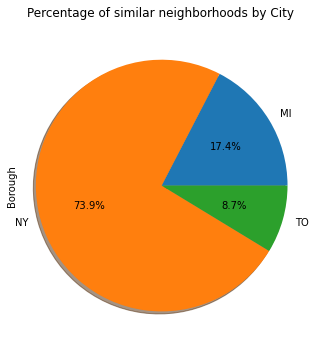

In [233]:
pie_chart_totals['Borough'].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', # add in percentages
                            shadow=True,       # add shadow      
                            )

plt.title('Percentage of similar neighborhoods by City')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

In [235]:
#now lets plot where these neighborhoods are in NY

master_merged_159=master_merged.loc[master_merged['Cluster Labels'] == 159]
master_merged_ny=master_merged_159.loc[master_merged_159['City'] == "NY"]

In [237]:

hoods = folium.map.FeatureGroup()
address="New York City, US"
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
master_map = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, in zip(master_merged_ny.Latitude, master_merged_ny.Longitude):
    hoods.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
master_map.add_child(hoods)

### lets find neighborhoods that have some competiton

In [239]:
#we will find those neighbhorhoods that have within the 1st, 2nd and 3rd most common venue a pizza place or an italian restauran since these might offer pìzza as well

master_merged1stItalian=master_merged_159.loc[master_merged_159['1st Most Common Venue'].str.contains("Italian")]
master_merged1stPizza=master_merged_159.loc[master_merged_159['1st Most Common Venue'].str.contains("Pizza")]
master_merged2ndItalian=master_merged_159.loc[master_merged_159['2nd Most Common Venue'].str.contains("Italian")]
master_merged2ndPizza=master_merged_159.loc[master_merged_159['2nd Most Common Venue'].str.contains("Pizza")]
master_merged3rdItalian=master_merged_159.loc[master_merged_159['3rd Most Common Venue'].str.contains("Italian")]
master_merged3rdItalian=master_merged_159.loc[master_merged_159['3rd Most Common Venue'].str.contains("Pizza")]

In [240]:
tophoods=master_merged1stItalian.append(master_merged1stPizza)
tophoods=tophoods.append(master_merged2ndItalian)
tophoods=tophoods.append(master_merged2ndPizza)
tophoods=tophoods.append(master_merged3rdItalian)
tophoods=tophoods.append(master_merged3rdItalian)
tophoods

,Borough,Neighborhood,Latitude,Longitude,City,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
209,Manhattan,Greenwich Village,40.7269,-73.9999,NY,159,Italian Restaurant,Clothing Store,Sushi Restaurant,American Restaurant,Boutique,Café,Indian Restaurant,Bakery,Gym,Coffee Shop
340,Manhattan,Noho,40.7233,-73.9884,NY,159,Italian Restaurant,Art Gallery,Coffee Shop,Mexican Restaurant,Pizza Place,French Restaurant,Grocery Store,Sushi Restaurant,Café,Vegetarian / Vegan Restaurant
368,Manhattan,Flatiron,40.7397,-73.9909,NY,159,Italian Restaurant,Japanese Restaurant,New American Restaurant,Sporting Goods Shop,American Restaurant,Wine Shop,Spa,Coffee Shop,Mediterranean Restaurant,Furniture / Home Store
399,Brickell,Brickell,25.7634,-80.1955,MI,159,Hotel,Italian Restaurant,Bar,Seafood Restaurant,Pizza Place,Pharmacy,Japanese Restaurant,Argentinian Restaurant,Yoga Studio,Spa


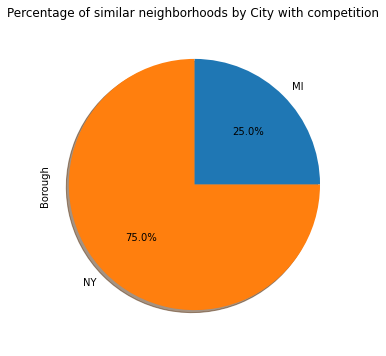

In [241]:
pie_chart_totalsfinal=tophoods.groupby(["City"]).count()

pie_chart_totalsfinal['Borough'].plot(kind='pie',
                            figsize=(5, 6),
                            autopct='%1.1f%%', # add in percentages
                            shadow=True,       # add shadow      
                            )

plt.title('Percentage of similar neighborhoods by City with competition')
plt.axis('equal') # Sets the pie chart to look like a circle.

plt.show()

In [242]:

hoods = folium.map.FeatureGroup()
address="New York City, US"
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
master_map = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, in zip(tophoods.Latitude, tophoods.Longitude):
    hoods.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
master_map.add_child(hoods)

In [243]:
hoods = folium.map.FeatureGroup()
address="Miami, US"
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
master_map = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, in zip(tophoods.Latitude, tophoods.Longitude):
    hoods.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
master_map.add_child(hoods)